In [188]:
from dfply import *

In [146]:
import pandas as pd

In [147]:
import os

In [148]:
os.chdir(r'D:\03lecture\QT\codeBackup\data')

In [149]:
msf = pd.read_csv('msf.csv')

In [150]:
mse = pd.read_csv('mse.csv')

In [151]:
mse.PAYDT = mse.PAYDT.apply(str)

In [152]:
mse.PAYDT = pd.to_datetime(mse.PAYDT,format = '%Y%m%d')

In [153]:
mse['Paymonth'] = mse.PAYDT.apply(lambda x:x.month)

In [154]:
mse['PayYear'] = mse.PAYDT.apply(lambda x:x.year)

In [155]:
div = mse.dropna(subset = ['DISTCD'])
div['DISTCD'] = div['DISTCD'].astype(str)
div.insert(loc = 2,column = 'freq',value = div['DISTCD'].apply(lambda x:x[:3]))
## filter out the stocks that pay dividends

C:\Users\sherrywei\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [156]:
len(div)

833285

In [157]:
divPayCom = div[div['freq'].isin(['123','124','125'])]

In [158]:
divPayCom.shape

(559508, 9)

In [159]:
##如果是季度支付股息，那么三个月前支付过股息，这个月就会支付股息。

In [160]:
## portfolio 2 long companies in the month of their predicted dividend month, and short 
##same companies in other months

In [161]:
divPayCom.columns

Index(['PERMNO', 'DISTCD', 'freq', 'DIVAMT', 'DCLRDT', 'EXDT', 'PAYDT',
       'Paymonth', 'PayYear'],
      dtype='object')

In [162]:
divComList = list(set(divPayCom['PERMNO']))

In [163]:
msf.date = pd.to_datetime(msf.date,format = '%Y%m%d')

In [164]:
msf.sort_values(by = ['PERMNO','date'],inplace = True)

In [165]:
msf['prc_lag1'] = msf.groupby(['PERMNO'])['PRC'].shift(1)

In [166]:
msf = msf.query('RET != "B"&RET != "C"')

In [167]:
msf_divCom = msf.query('PERMNO in(@divComList)')

In [168]:
msf_divCom.dtypes

PERMNO               int64
date        datetime64[ns]
SHRCD              float64
HEXCD                int64
BIDLO              float64
ASKHI              float64
PRC                float64
VOL                float64
RET                 object
BID                float64
ASK                float64
SHROUT             float64
SPREAD             float64
RETX                object
prc_lag1           float64
dtype: object

In [169]:
msf_divCom.date = pd.to_datetime(msf_divCom.date,format = '%Y%m%d')

C:\Users\sherrywei\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [170]:
def end_of_month(any_day):
    next_month = any_day.replace(day=28) + datetime.timedelta(days=4)  # this will never fail
    return next_month - datetime.timedelta(days=next_month.day)

In [171]:
import datetime

In [172]:
msf_divCom['end_of_month'] = msf_divCom['date'].apply(end_of_month)

C:\Users\sherrywei\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [173]:
divPayCom.dropna(subset = ['PAYDT'],inplace = True)

C:\Users\sherrywei\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [174]:
divPayCom['end_of_month'] = divPayCom.PAYDT.apply(end_of_month)

C:\Users\sherrywei\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [175]:
divPayCom.columns 

Index(['PERMNO', 'DISTCD', 'freq', 'DIVAMT', 'DCLRDT', 'EXDT', 'PAYDT',
       'Paymonth', 'PayYear', 'end_of_month'],
      dtype='object')

In [176]:
mse.columns

Index(['PERMNO', 'DISTCD', 'DIVAMT', 'DCLRDT', 'EXDT', 'PAYDT', 'Paymonth',
       'PayYear'],
      dtype='object')

In [339]:
divComInfo = pd.merge(msf_divCom,divPayCom[['PERMNO','DISTCD','DIVAMT','freq','PAYDT','Paymonth','PayYear','end_of_month']],
                     on = ['PERMNO','end_of_month'],
                     how = 'outer')

In [340]:
divComInfo.dropna(subset = ['SHRCD'],inplace = True)


In [341]:
divComInfo =divComInfo >> arrange(X.PERMNO, X.end_of_month)

In [342]:
divComInfo['freq'].fillna(method = 'ffill',inplace = True)

In [343]:
divComInfo.insert(loc = 2,column= 'month',value = divComInfo.date.apply(lambda x:x.month))

In [344]:
divComInfo['freq_lag1'] = divComInfo.groupby(['PERMNO','month'])['freq'].shift(1)

In [345]:
divComInfo['mcap'] = divComInfo['PRC']*divComInfo['SHROUT']

In [346]:
divComInfo.sort_values(by = ['PERMNO','date'],inplace = True)

In [347]:
divComInfo['mcap_lag1'] = divComInfo.groupby(['PERMNO'])['mcap'].shift(1)

In [348]:
divComInfo = divComInfo >> arrange(X.PERMNO, X.end_of_month)

In [349]:
divComInfo['DIV_lag3'] = divComInfo.groupby('PERMNO')['DIVAMT'].shift(2)

divComInfo['DIV_lag6'] = divComInfo.groupby('PERMNO')['DIVAMT'].shift(5)

divComInfo['DIV_lag12'] = divComInfo.groupby('PERMNO')['DIVAMT'].shift(11)

In [350]:
## filter stocks
   #price larger than 5
   #HEXCD 123
   #SHRCD 10，11

In [351]:
divComInfo = divComInfo.query('prc_lag1 >= 5&HEXCD in([1,2,3]) & SHRCD in([10,11])&RET != "B"&RET != "C"')

In [352]:
for col in ['BIDLO','ASKHI','SPREAD','BID','ASK','VOL']:
    try:
        divComInfo.pop(col)
    except:
        continue

In [353]:
import numpy as np

In [354]:
divComInfo.freq_lag1 = divComInfo.freq_lag1.astype('float')

In [355]:
divComInfo = divComInfo >> arrange(X.end_of_month)

In [356]:
divComInfo = divComInfo.query('end_of_month <= "2011-12-31" ')

In [357]:
long = divComInfo.query('(freq == "123" & DIV_lag3 == DIV_lag3) |'
                        '(freq == "124" & DIV_lag6 == DIV_lag6) |'
                        '(freq == "125" & DIV_lag12 == DIV_lag12)')

In [358]:
long[["PERMNO","end_of_month","DIVAMT","DIV_lag3"]]

,PERMNO,end_of_month,DIVAMT,DIV_lag3
90660,10989,1927-03-31,NaN,0.5000
403882,15624,1927-03-31,NaN,0.5000
100093,11092,1927-03-31,NaN,0.2887
187020,12108,1927-03-31,NaN,0.5000
359958,14867,1927-03-31,NaN,0.8750
137868,11543,1927-03-31,NaN,1.0000
305402,13987,1927-03-31,NaN,1.5000
291146,13741,1927-03-31,NaN,0.5000
106059,11164,1927-03-31,NaN,1.5000
136592,11527,1927-03-31,NaN,1.5000


In [359]:
long.RET = long.RET.apply(float)

C:\Users\sherrywei\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [360]:
long = long.groupby("end_of_month")["RET"].agg(["mean"])

In [361]:
long['cumulative_ret'] = np.cumprod(1+long['mean'])

In [362]:
long >> tail

,mean,cumulative_ret
end_of_month,,
2011-08-31,-0.062076,226745.438818
2011-09-30,-0.085106,207448.000386
2011-10-31,0.125943,233574.696925
2011-11-30,0.007572,235343.222315
2011-12-31,0.006662,236911.006591


In [363]:
short = divComInfo.query('(freq == "123" & DIV_lag3 != DIV_lag3) |'
                        '(freq == "124" & DIV_lag6 != DIV_lag6) |'
                        '(freq == "125" & DIV_lag12 != DIV_lag12)')

In [364]:
short.RET = short.RET.apply(float)

C:\Users\sherrywei\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [365]:
short = short.groupby("end_of_month")["RET"].agg(["mean"])

In [366]:
short['cumulative_ret'] = np.cumprod(1+short['mean'])

In [367]:
short >> tail()

,mean,cumulative_ret
end_of_month,,
2011-08-31,-0.075519,15441.838377
2011-09-30,-0.099115,13911.324331
2011-10-31,0.137673,15826.540625
2011-11-30,-0.004326,15758.077349
2011-12-31,0.004728,15832.574915


In [374]:
port_long_short = long[['mean']].join(short[['mean']],how = 'outer',lsuffix='_long', rsuffix='_short')

In [387]:
port_long_short['monthly_ret'] = port_long_short['mean_long'] -port_long_short['mean_short']

In [388]:
port_long_short['cumulative_ret'] = np.cumprod(port_long_short['monthly_ret']+1)

In [389]:
port_long_short.tail()

,mean_long,mean_short,monthly_ret,cumulative_ret
end_of_month,,,,
2011-08-31,-0.062076,-0.075519,0.013444,5.546445
2011-09-30,-0.085106,-0.099115,0.014009,5.624143
2011-10-31,0.125943,0.137673,-0.011730,5.558173
2011-11-30,0.007572,-0.004326,0.011897,5.624301
2011-12-31,0.006662,0.004728,0.001934,5.635179


In [81]:
portfolio_long = pd.concat([quarterlyDiv_long,semiAn_long,Annual_long])

In [82]:
portfolio_long.RET = portfolio_long.RET.astype('float')

In [83]:
port_long = pd.DataFrame(portfolio_long.groupby('date')['RET'].mean())

In [84]:
portfolio_short = divComInfo.loc[short]

In [114]:
portfolio_short.RET = portfolio_short.RET.astype('float')

In [115]:
portfolio_short.RET = portfolio_short.RET*-1

In [131]:
port_short = pd.DataFrame(portfolio_short.groupby('date')['RET'].mean())

In [133]:
port_short.head()

,RET
date,
1927-02-28,-0.058663
1927-03-31,0.007930
1927-04-30,-0.002879
1927-05-31,-0.060658
1927-06-30,0.016588


In [97]:
port_long.mean()

RET    0.010089
dtype: float64

In [134]:
port_long_short = port_long.join(port_short,how = 'outer',lsuffix='_long', rsuffix='_short')

In [135]:
port_long_short.dropna(inplace = True)

In [136]:
port_long_short['monthly_ret'] =port_long_short['RET_long'] + port_long_short['RET_short'] 

In [137]:
port_long_short['cumulative_ret'] = np.cumprod(1+port_long_short['monthly_ret'])

In [138]:
port_long_short['monthly_ret'].mean()

-0.002113793243037131

In [139]:
import matplotlib.pyplot as plt

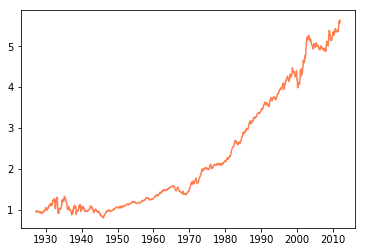

In [383]:
plt.figure()
x = port_long_short.index
y = port_long_short.cumulative_ret
plt.plot(x,y,color = 'coral')
plt.show()

In [ ]:
divComInfo.RET = divComInfo.RET.astype('float')

In [ ]:
portfolio_short['RET'] = portfolio_short['RET']*-1

In [ ]:
port_long_short = pd.concat([portfolio_long,portfolio_short]).reset_index()

In [ ]:
port_long_short.sort_values(['PERMNO','date'],inplace = True)

In [ ]:
port_long_short['RET'] = port_long_short['RET'].astype('float')

In [ ]:
portfolio_long.shape

In [ ]:
len(short)

In [ ]:
len(long)